In [7]:
import numpy as np
import sklearn as sk
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = '/Users/apple/Downloads/data/'
data = 'Electricity_Theft_Data.csv'
print('current data path',os.path.join(data_path, data))
os.chdir(os.path.join(data_path))

# read data 
theft_df = pd.read_csv(os.path.join(data_path, data))
print('cols:',theft_df.shape[1], 'rows: ', theft_df.shape[0])
print('unique customers:', theft_df['CONS_NO'].nunique())

current data path /Users/apple/Downloads/data/Electricity_Theft_Data.csv
cols: 367 rows:  9957
unique customers: 9956


The dataset contains missing consumption data for the entire year. Some accounts do not have energy consumption for more than 6 months
and there are accounts where no consumption data available for entire month.

To solve this problem we will calculate median value of consumption of each consumer yearly and impute NAN values with the median values. 
The missing values are imputed with median as there are some outliers in the positive class and may indicate anomaly. So the mean and median values of the positive class are preserved.

In this way we only considering the consumption pattern of each consumer rather than all consumers.

Once the missing values are imputed, we will roll up the data and calculate weekly consumption for each consumer.

In [4]:
# for missing value treatment we go drop rows original data frame because there are accounts where at least 3 months consumption data is not recorded
print('before deleting missing values, the number of cols:',theft_df.shape[1], 'and number of rows: ', theft_df.shape[0])
theft_df = theft_df.dropna(thresh=180) # delete accounts where at least 6 months of energy data not available
theft_df = theft_df.dropna(subset='CONS_NO') ## delete where account number is null
print('after deleting missing values, the number of cols:',theft_df.shape[1], 'and number of rows: ', theft_df.shape[0])

before deleting missing values, the number of cols: 367 and number of rows:  9957
after deleting missing values, the number of cols: 367 and number of rows:  9549


In [5]:
# transform the data frame from column to rows
transformed_df = pd.melt(frame= theft_df, id_vars=["CONS_NO", "CHK_STATE"], var_name= "date" , value_name= "consumption")

# change the column data types and extract month, year and week
transformed_df['CONS_NO'] = transformed_df["CONS_NO"].astype(int)
transformed_df['CHK_STATE'] = transformed_df["CHK_STATE"].astype(int)
transformed_df['date'] = pd.to_datetime(transformed_df['date'], infer_datetime_format= True, dayfirst= True)
transformed_df['month'] = transformed_df['date'].dt.month
transformed_df['year'] = transformed_df['date'].dt.year
transformed_df['week'] = transformed_df['date'].dt.isocalendar().week

# aggregate the median value of consumption by consumer and year impute NAN values with the imputed values
transformed_df['Consumption_imputed_by_year'] = transformed_df.groupby(['CONS_NO', 'year'])['consumption'].transform(lambda x: x.fillna(x.median()))
print('% of missing values', transformed_df.isnull().mean().to_frame('avg_missing_values'))

# select the required columns
df_consumption_week = transformed_df[['CONS_NO', 'week', 'Consumption_imputed_by_year', 'CHK_STATE']]
print('Positive Classes :', df_consumption_week['CHK_STATE'].value_counts()[0])
print('Negative Classes :', df_consumption_week['CHK_STATE'].value_counts()[1])

% of missing values                              avg_missing_values
CONS_NO                                0.000000
CHK_STATE                              0.000000
date                                   0.000000
consumption                            0.111008
month                                  0.000000
year                                   0.000000
week                                   0.000000
Consumption_imputed_by_year            0.000000
Positive Classes : 3045195
Negative Classes : 440190


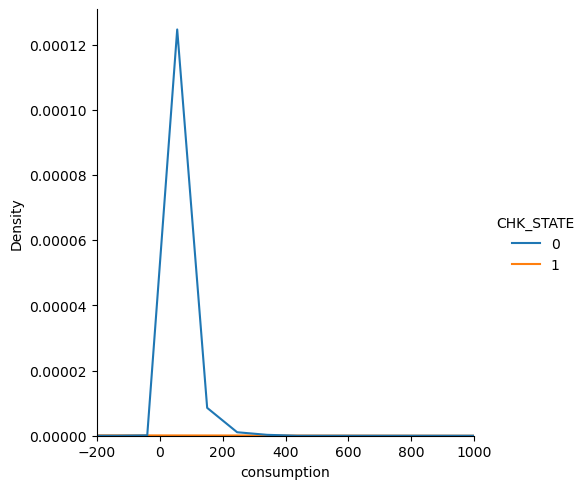

In [6]:
# visualization to understand the distribution of consumption pattern
sns.displot(data = transformed_df, x = 'Consumption_imputed_by_year', kind= 'kde', hue ='CHK_STATE')
plt.xlim(-200, 1000)
plt.xlabel('consumption')
plt.show()

a different distribution of positive and negative classes observed

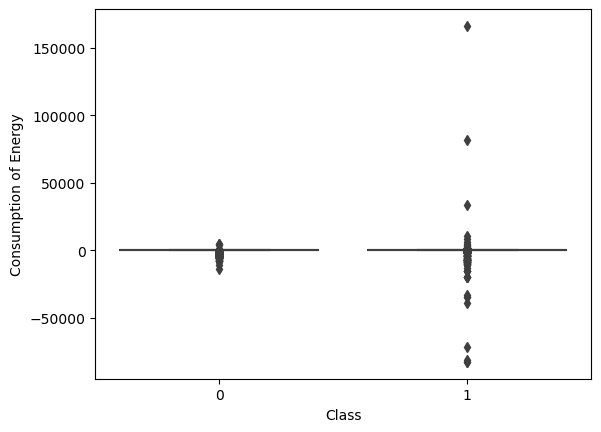

In [8]:
sns.boxplot(data=transformed_df, x="CHK_STATE", y="Consumption_imputed_by_year")
plt.xlabel('Class')
plt.ylabel('Consumption of Energy')
plt.show()

In [8]:
# the column week is modified 
df_consumption_week.loc[:, 'week'] = df_consumption_week['week'].apply(lambda x: f'week_{str(x)}')
# the data frame is pivoted back to its original shape
df_consumption = pd.DataFrame(pd.pivot_table(data= df_consumption_week, index = ['CONS_NO', 'CHK_STATE'], columns= 'week',   values= 'Consumption_imputed_by_year').reset_index())

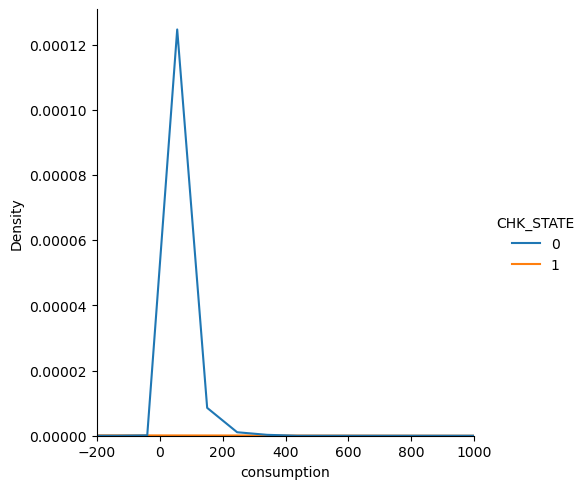

In [14]:
# asses the consumption distribution again 
sns.displot(data = df_consumption_week, x = 'Consumption_imputed_by_year', kind= 'kde', hue ='CHK_STATE')
plt.xlim(-200, 1000)
plt.xlabel('consumption')
plt.show()